# Teste Técnico de Modelagem - Oncase

O presente projeto foi realizado como parte do processo seletivo da empresa Oncase. O desafio foi dividido em 3 problemas: de regressão, classificação e prrevisão de séries temporais.

Para cada um desses problemas foi fornecida uma base de dados (ou 2, dividas em arquivo de treino e teste).

### Preparando o ambiente

In [76]:
#Bibliotecas essenciais
import os
import warnings

import pandas as pd #Processamento e manipulação de dados
import numpy as np #Processamento de matrizes e funções matemáticas
import math #Funções matemáticas

from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição de séries temporais
from statsmodels.tsa.stattools import adfuller #Teste de estacionariedade
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

#Bibliotecas gráficas
import matplotlib.pyplot as plt
import seaborn as sns

#Bibliotecas para Modelagem
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

#Bibliotecas para avaliação do modelo
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore') #Ocultando avisos
%matplotlib inline

In [71]:
# Helper functions

def rmse(true, pred):
    #Calculando o Root Mean Squared Error
    return math.sqrt(mean_squared_error(true,pred))

def mape(true, pred):
    # Calculando o erro percentual absoluto médio
    y_true, y_pred = np.array(true), np.array(pred)
    return np.mean(np.abs(y_true - y_pred) / y_true)

def Croston(ts,extra_periods=1,alpha=0.4):
    # Definindo um modelo de Croston Básico

    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation
    
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):        
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1           
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1
       
    # Future Forecast 
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.1):
    # Definindo um modelo de Croston TSB
    
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods
    
    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]
                 
    # Create all the t+1 forecasts
    for t in range(0,cols): 
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t] 
            p[t+1] = beta*(1) + (1-beta)*p[t]  
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]       
        f[t+1] = p[t+1]*a[t+1]
        
    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]
                      
    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

### Problema de Regressão

In [72]:
# Carregando datasets de treino e teste

os.chdir(r'C:\Users\mathe\OneDrive\Área de Trabalho\Teste Oncase\Datasets\regression_data')

train = pd.read_csv('regression_train.csv')
test = pd.read_csv('regression_test.csv')

train.head()

,target,X1,X2,X3,X4,X5,X6,X7
0,NaN,-0.546168,NaN,47.063305,1.611370,-65.882137,0,-16.672865
1,47.735389,3.074317,-2.836000,49.396649,0.261998,-66.570716,0,-6.664599
2,NaN,-1.485531,-13.102537,42.367991,3.991558,-67.108014,8,-30.790962
3,908.202209,6.907396,-0.308967,57.228787,0.256771,-66.181266,5,-0.726072
4,1640.461863,1.916788,3.460290,51.703375,2.463790,-65.143663,5,8.131680


In [73]:
print('Shape: ',train.shape) # Fromato do dataset
print(train.info()) # Analisando tipo dos dados das colunas

Shape:  (1042, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1042 entries, 0 to 1041
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  715 non-null    float64
 1   X1      1042 non-null   float64
 2   X2      1031 non-null   float64
 3   X3      1042 non-null   float64
 4   X4      1042 non-null   float64
 5   X5      1042 non-null   float64
 6   X6      1042 non-null   int64  
 7   X7      1042 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 65.2 KB
None


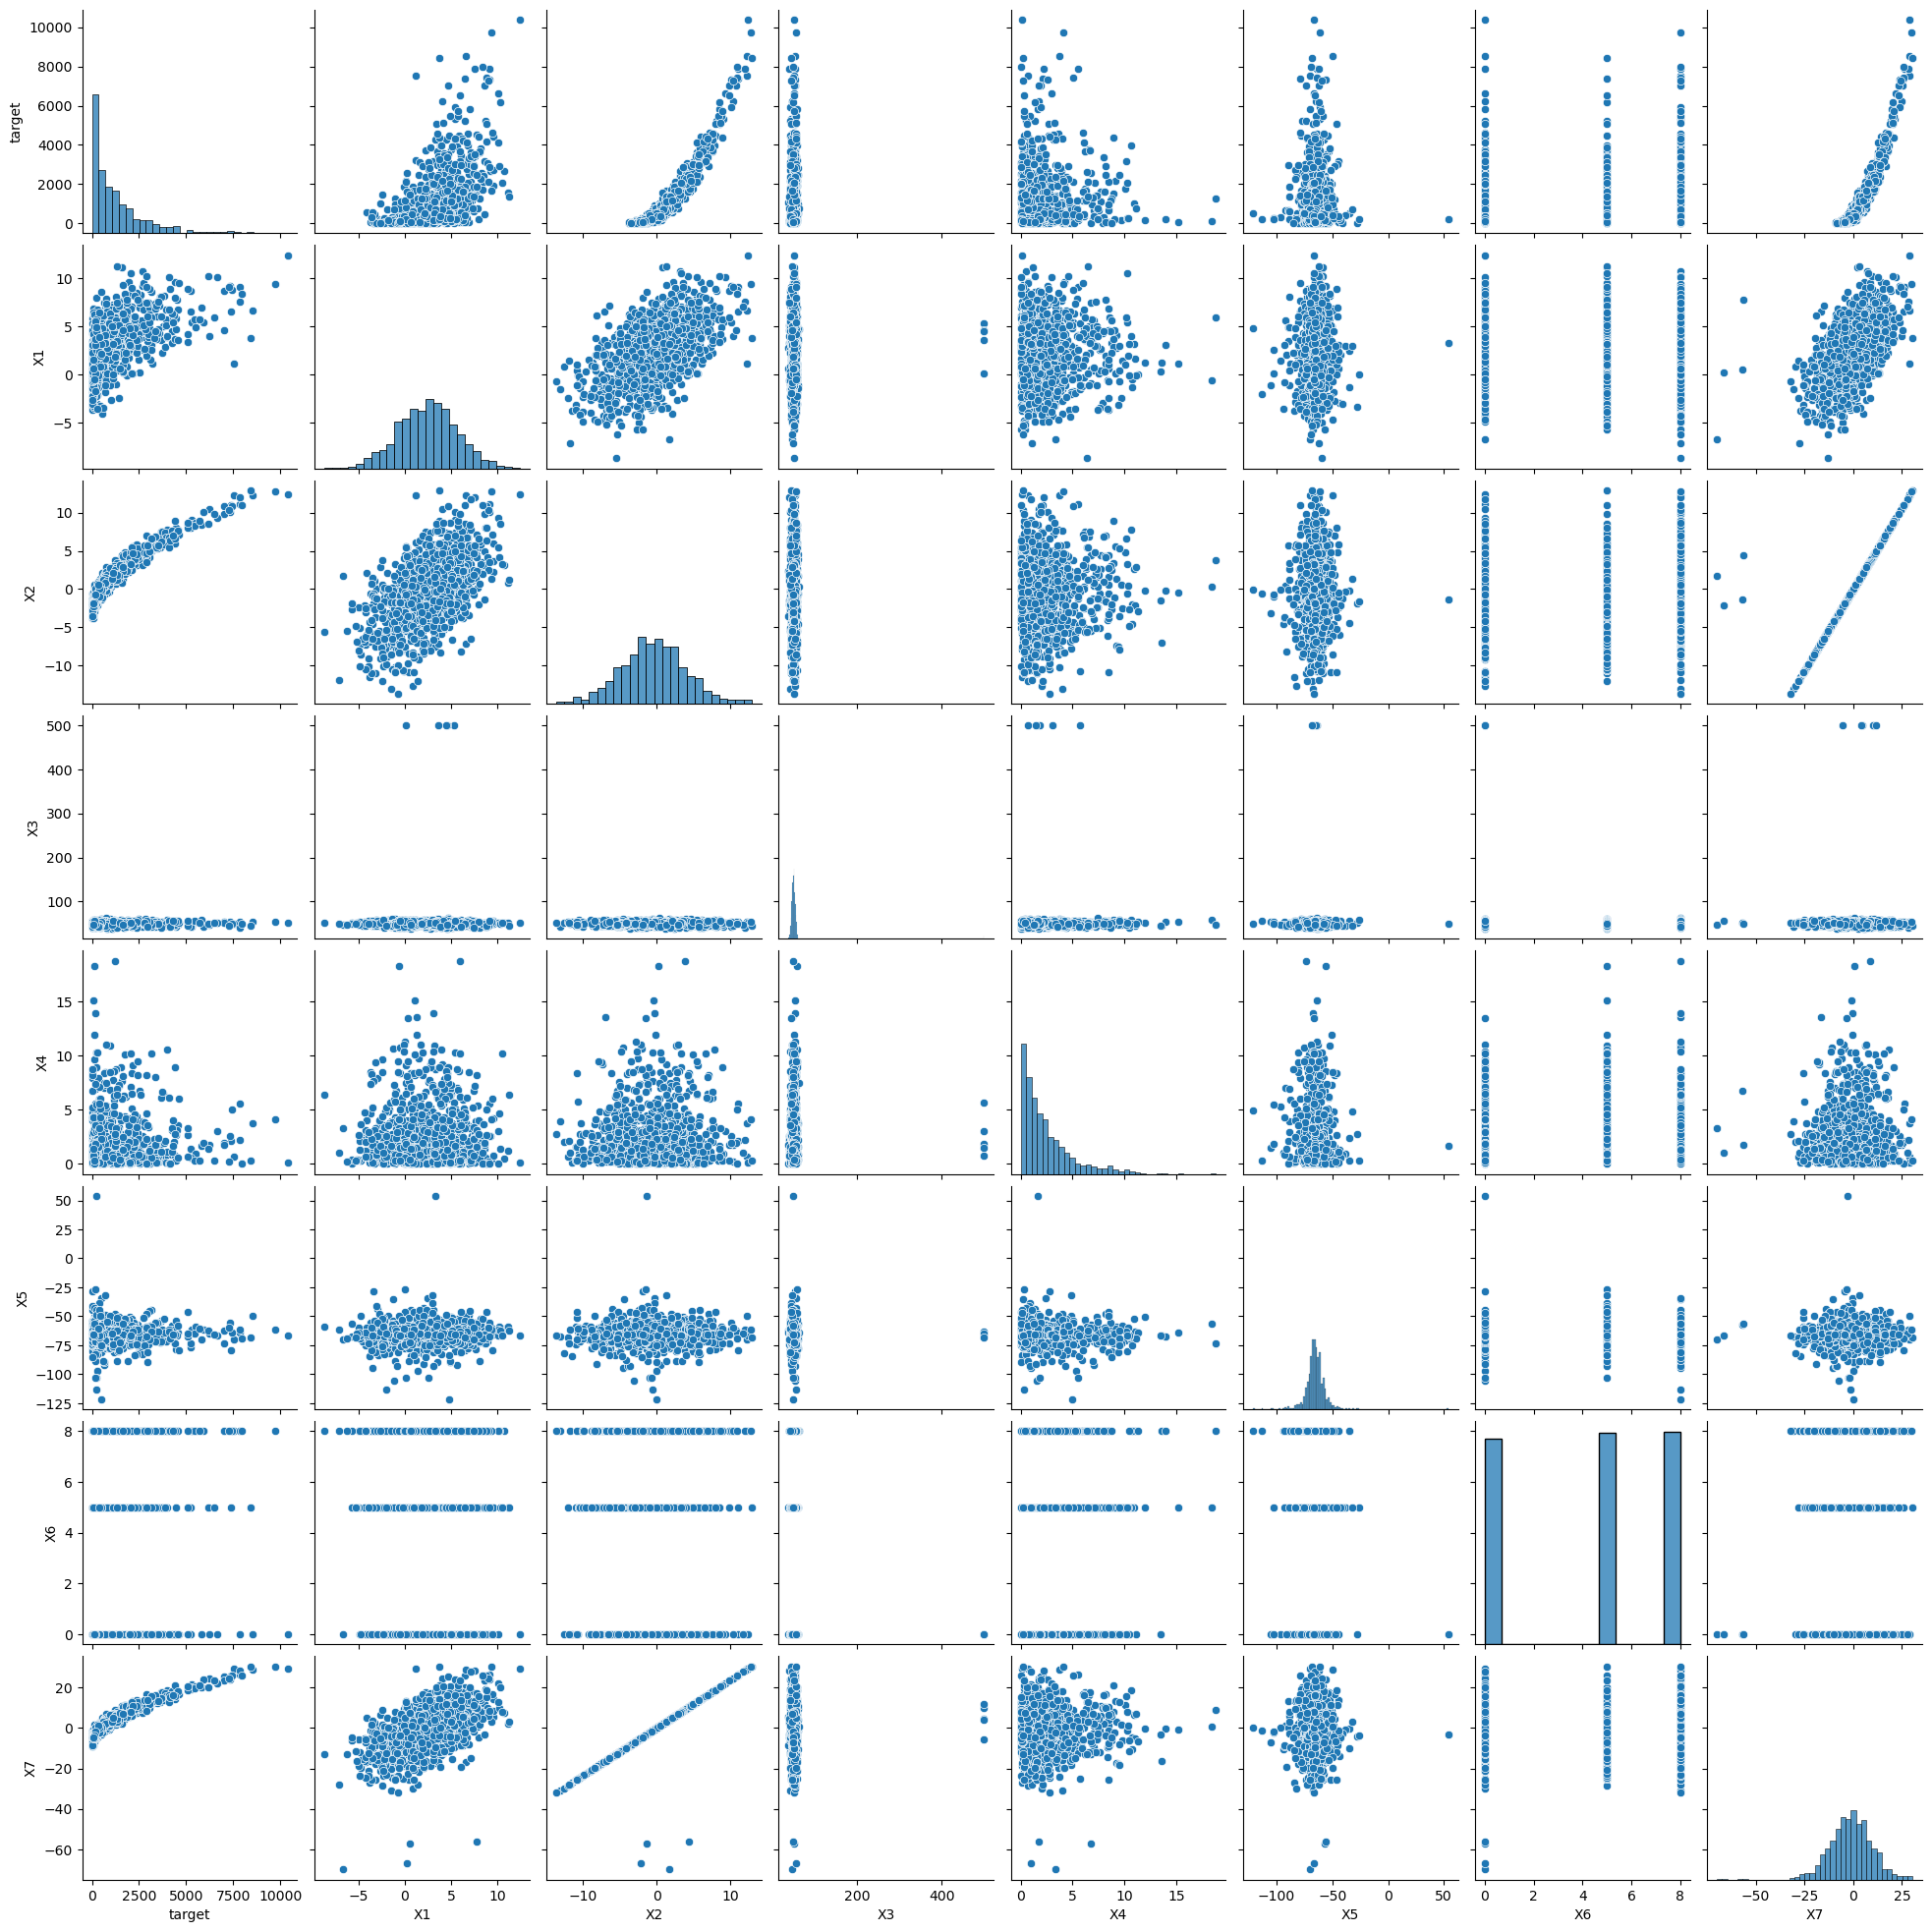

In [77]:
sns.pairplot(train) # Visualizando relação entre as variáveis

In [62]:
train.corr() # Correlação entre as variáveis

,target,X1,X2,X3,X4,X5,X6,X7
target,1.000000,0.514485,0.938318,0.057441,-0.011001,-0.023407,0.040508,0.938318
X1,0.514485,1.000000,0.559405,0.025361,-0.029827,0.042807,-0.022386,0.540101
X2,0.938318,0.559405,1.000000,0.038829,0.018959,0.010514,0.014259,0.932566
X3,0.057441,0.025361,0.038829,1.000000,0.008004,-0.003092,-0.093812,0.043176
X4,-0.011001,-0.029827,0.018959,0.008004,1.000000,-0.059369,-0.022158,0.012061
X5,-0.023407,0.042807,0.010514,-0.003092,-0.059369,1.000000,-0.027672,0.003798
X6,0.040508,-0.022386,0.014259,-0.093812,-0.022158,-0.027672,1.000000,0.037851
X7,0.938318,0.540101,0.932566,0.043176,0.012061,0.003798,0.037851,1.000000


Analisando o dataset, é possível observar os seguintes pontos:

 - É composto por 7 variáveis independentes (X1 - X7) e uma variável independente (target). Além disso, possui 1042 linhas
 - A variável 'target' tem 27 valores faltantes que precisam ser tratados.
 - Os tipos das variáveis estão em float ou integer, portanto, não será necessário tratá-las
 - É possível observar que as variáveis X3, X4 e X5 apresentam um baixo coeficiente de correlação e a variável X6 não parece ser contínua.

In [63]:
# Excluindo linhas com valores nulos
train_clean = train.dropna()
test_clean = test.dropna()

#Separando em variáveis independentes (X) e dependente (y)
X_train = train_clean.drop(['target'],axis=1)
y_train = train_clean['target']

X_test = test_clean.drop(['target'],axis=1)
y_test = test_clean['target']

Para a preparação dos dados, foram realizadas apenas 2 etapas de preprocessamento:
- Exclusão das linhas com valores nulos
- Separação dos datasets em variáveis independentes (X) e dependente (y)

É importante mencionar que, tendo em vista que um dos objetivos do projeto é identificar a variável que mais impacta o nosso 'target', será realizada uma analise dos coeficientes do regressor. Por isso, as features não serão normalizadas.

#### Regressão Linear

Evaluation metrics: 

R2:  0.8976175245733274
RMSE:  404.20243974379804
Correlation: 0.9540636645440772


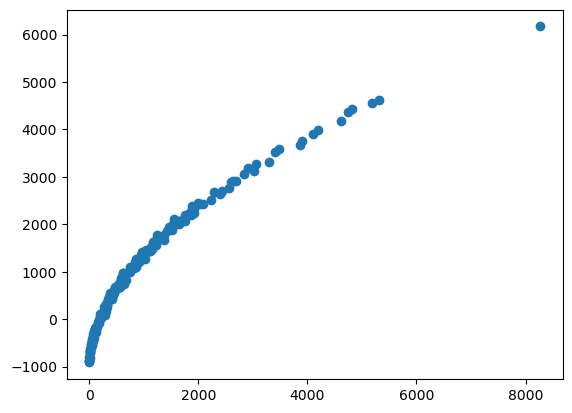

In [66]:
reg = LinearRegression().fit(X_train, y_train) # Gerando regressor


pred = reg.predict(X_test) # Realizando previsão com o dataset de teste
pred_df=pd.DataFrame(pred.reshape(-1,1)) 

# Avaliando o modelo
print("Evaluation metrics: \n")
print("R2: ", r2_score(y_test,pred))
print("RMSE: ", rmse(y_test,pred))
print("Correlation:", pearsonr(y_test,pred)[0])

df_true_pred = pd.concat([pd.DataFrame(y_test).reset_index(drop=True),pred_df],axis=1)
plt.scatter(df_true_pred['target'],df_true_pred[0])
plt.show()

  Features  Coefficients
0       X1     97.055487
1       X2     66.376099
2       X3     18.536342
3       X4    -61.279471
4       X5      2.913618
5       X6     -3.002376
6       X7    155.983833

 ----------- 

Corr(X7,target):  0.9383182085362961

 ----------- 



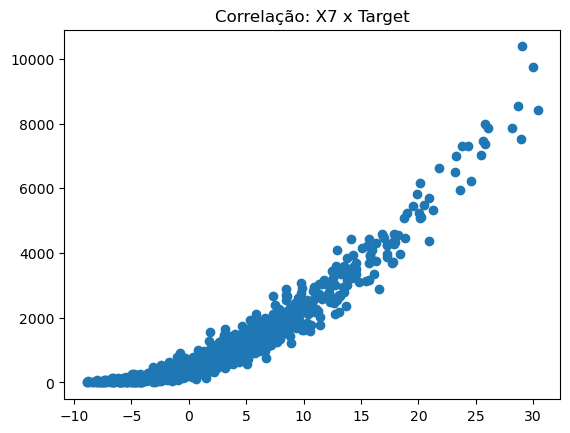

In [67]:
# Avaliando coeficientes 

cols = X_train.columns
coef = reg.coef_


print(pd.DataFrame({"Features":cols, "Coefficients":coef}))
print('\n ----------- \n')
print("Corr(X7,target): ",train['X7'].corr(train['target']))
print('\n ----------- \n')
plt.scatter(X_train['X7'],y_train)
plt.title("Correlação: X7 x Target")
plt.show()

Apesar de ser um modelo base, utilizando a regressão linear foi possível alcançar métricas satisfatóricas, conforme apresentado:

- R2: implica que 89% da variação da variável alvo é explicada pelas variáveis independentes.

- RMSE (Raiz do Erro quadrado Médio): é uma métrica útil para a avaliação do modelo, principalmente, quando o problema exige uma penalização de erros grandes. É aplicado no caso de problemas nos quais um erro muito grande na previsão é mais custoso do que vários erros pequenos.

Além do modelo apresentado, também foram testadas regressões excluindo as features com correlação nula com a variável target, porém essa remoção acarretou em resultados piores nas métricas de avaliação.

Ao comparar os coeficientes do regressor, podemos observar que a variável X7 apresenta o maior valor em módulo. Isso significa que uma variação em X7 é a que apresenta maior impacto no target.

Fazendo uma análise de correlação direta entre as 2 variáveis nos mostra que a correlação entre as 2 é de 0.94

### Problema de Classificação

In [78]:
# Carregando datasets de treino e teste

os.chdir(r'C:\Users\mathe\OneDrive\Área de Trabalho\Teste Oncase\Datasets\classification_data')

train2 = pd.read_csv('classification_train.csv')
test2 = pd.read_csv('classification_test.csv')

train2.head(5)

,x1,x2,target
0,1.934224,-0.111822,1
1,1.767383,-0.976402,1
2,0.937101,-0.085633,1
3,1.340732,0.166960,1
4,-0.199901,-0.155204,1


In [79]:
print('Nulos: ',train2.isnull().sum()) # Identificando valores nulos

Nulos:  x1        0
x2        0
target    0
dtype: int64


In [80]:
train2.info() # Avaliando tipo dos dados das colunas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 670 entries, 0 to 669
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x1      670 non-null    float64
 1   x2      670 non-null    float64
 2   target  670 non-null    int64  
dtypes: float64(2), int64(1)
memory usage: 15.8 KB


<AxesSubplot:ylabel='Frequency'>

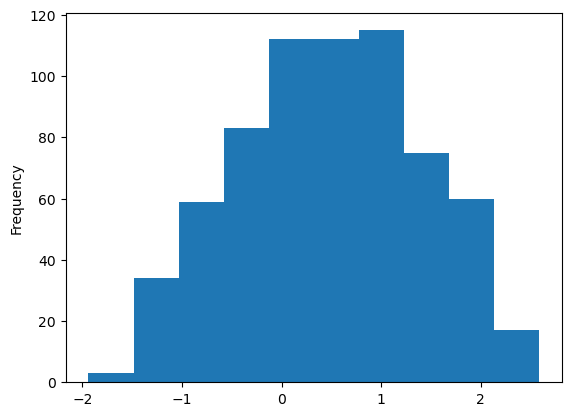

In [81]:
train2.x1.plot(kind='hist') 

<AxesSubplot:ylabel='Frequency'>

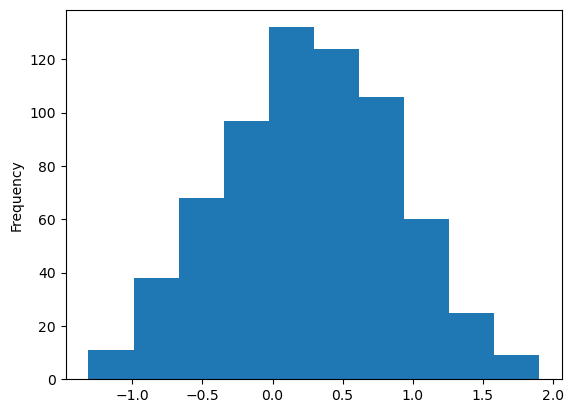

In [82]:
train2.x2.plot(kind='hist')

<AxesSubplot:xlabel='target', ylabel='count'>

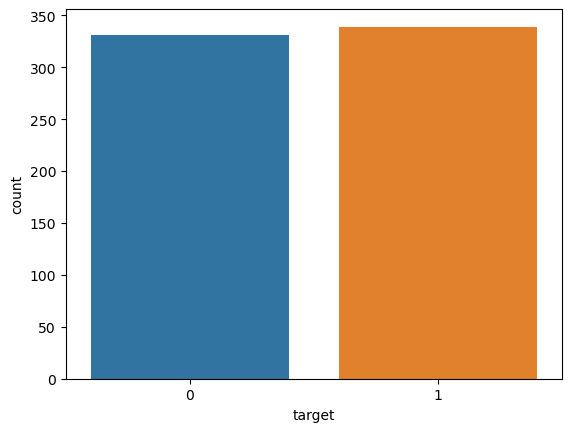

In [83]:
sns.countplot(data=train2, x='target') # Avaliando balanceamento da variável alvo

Analisando o dataset, é possível observar os seguintes pontos:

 - É composto por 2 variáveis independentes (x1 e x2) e uma variável independente binária (target). Além disso, possui 670 linhas
 - O dataset não apresenta valores faltantes
 - Os tipos das variáveis estão em float ou integer, portanto, não será necessário tratá-las
 - A variável target está balanceada (ou seja, apresenta um peso equivalente de eventos positivos e negativos). Essa é uma condição importante para modelos de classificação.

In [84]:
# Separando entre datasets de treino e teste

X_train2 = train2.drop('target',axis=1)
y_train2 = train2['target']

X_test2 = test2.drop('target',axis=1)
y_test2 = test2['target']

O único preprocessamente implementado foi a separação entre os datasets em treino e teste.

#### Regressão Logística

Evaluation metrics: 

Accuracy:  0.8333333333333334
Precision:  0.8154761904761905
Recall:  0.8509316770186336
F1-Score:  0.8328267477203648
------------
  Features  Coefficients
0       x1      1.139179
1       x2     -3.278208


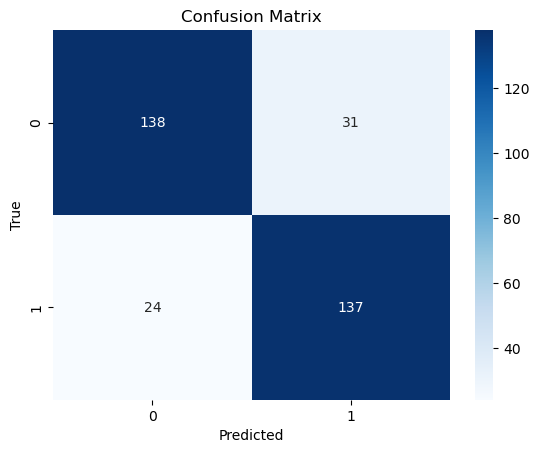

In [85]:
clf = LogisticRegression(random_state=0).fit(X_train2, y_train2) # Gerando regressor

pred2 = clf.predict(X_test2) # Realizando previsão

cols2 = X_train2.columns
coef2 = clf.coef_

#Avaliando modelo

sns.heatmap(confusion_matrix(y_test2, pred2),cmap='Blues', annot=True,fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('True')
plt.xlabel('Predicted')

print("Evaluation metrics: \n")
print("Accuracy: ", accuracy_score(y_test2,pred2))
print("Precision: ", precision_score(y_test2,pred2))
print("Recall: ", recall_score(y_test2,pred2))
print("F1-Score: ", f1_score(y_test2,pred2))
print('------------')
print(pd.DataFrame({"Features":cols2, "Coefficients":coef2[0]}))

Analisando os coeficientes da regressão logística, podemos concluir que a variável que exerce maior impacto no regressor é o x2, tendo em visa que o módulo do seu coeficiente é maior do que o da variável x1.

A medida de acurácia do modelo aponta que 83% das previsões feitas pelo regressor foram corretas. A precisão indica que dentre os eventos que o regressor previu como evento positivo, 81,5% foramde fato positivos. Já o recall indica que dentre todos os eventos positivos, 85% foram previstos corretamente pelo regressor.

### Problema de Séries Temporais

In [86]:
# Carregando datasets de treino e teste
os.chdir(r'C:\Users\mathe\OneDrive\Área de Trabalho\Teste Oncase\Datasets\time_series_data')
df = pd.read_excel('time_series_data.xlsx')
                                                    
df.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao
0,A0,23568,UN,14.13,20210420
1,A0,25082,UN,14.13,20210420
2,A0,25430,UN,14.13,20210922
3,A0,25463,UN,12.84,20210209
4,A0,25800,UN,12.84,20210209


In [87]:
df.info() # Analisanto tipo dos dados das colunas

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4460 entries, 0 to 4459
Data columns (total 5 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   produto_descricao                       4460 non-null   object 
 1   produto_quantidade                      4460 non-null   int64  
 2   produto_unidade_comercial               4460 non-null   object 
 3   produto_valor_unitario_comercializacao  4460 non-null   float64
 4   nota_data_emissao                       4460 non-null   int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 174.3+ KB


In [88]:
# Transformar nota_data_emissao em DateTime
df['nota_data_emissao']=pd.to_datetime(df['nota_data_emissao'], format='%Y%m%d')
# Criar coluna de valor total da venda
df['valor_total_venda'] = df['produto_quantidade']*df['produto_valor_unitario_comercializacao']

df.head()

,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao,valor_total_venda
0,A0,23568,UN,14.13,2021-04-20,333015.84
1,A0,25082,UN,14.13,2021-04-20,354408.66
2,A0,25430,UN,14.13,2021-09-22,359325.90
3,A0,25463,UN,12.84,2021-02-09,326944.92
4,A0,25800,UN,12.84,2021-02-09,331272.00


O dataset é composto por 5 colunas e 4460 linhas. Para a análise de demanda, será utilizada a colunas 'produto_quantidade'.

Inicialmente, é possível observar que a coluna 'nota_data_emissao' apresenta a data em um formato incomum. Por isso, é necessário tratá-la em transformá-la em datetime.

Também foi adicionada uma coluna com o valor total da venda multiplicado as colunas 'produto_quantidade' por 'produto_valor_unitario_comercializacao'

In [89]:
df['produto_descricao'].value_counts() # Contando observações de cada sku

B0    1000
B3     887
B2     778
A8     662
B1     536
B4     307
A9     141
D0      33
A0      32
B6      17
A7      14
A5       8
B7       6
A6       6
C5       4
C3       3
C0       3
C1       3
B8       2
B5       2
C2       2
C7       2
C9       2
D1       2
B9       1
A1       1
A3       1
C4       1
A4       1
C6       1
C8       1
A2       1
Name: produto_descricao, dtype: int64

In [90]:
df_B0 = df[df['produto_descricao']=='B0'] # Selecionando o produto B0

print('Registro mínimo de produtos: ', 
        df_B0['produto_quantidade'].min()) # Avaliando valor mínimo de quantidade registrada
print('Numero de datas duplicadas: ',df_B0['nota_data_emissao'].duplicated().sum())
df_B0[df_B0['nota_data_emissao'].duplicated()] # Contando colunas com datas de emissão duplicadas
df_B0.sort_values('nota_data_emissao',inplace=True) # Ordenando dataset pela data
df_B0

Registro mínimo de produtos:  1
Numero de datas duplicadas:  798


,produto_descricao,produto_quantidade,produto_unidade_comercial,produto_valor_unitario_comercializacao,nota_data_emissao,valor_total_venda
4395,B0,120,UN,29.50,2020-10-01,3540.00
3945,B0,14,UN,0.97,2020-10-02,13.58
3881,B0,1,UN,0.97,2020-10-05,0.97
3848,B0,25,UN,0.88,2020-10-07,22.00
3841,B0,3,UN,0.88,2020-10-07,2.64
...,...,...,...,...,...,...
898,B0,420,UN,32.47,2021-09-29,13637.40
101,B0,420,UN,32.02,2021-09-30,13448.40
2851,B0,60,UN,32.02,2021-09-30,1921.20
100,B0,180,UN,32.02,2021-09-30,5763.60


Para o projeto, é necessário selecionar apenas um sku para realizar a projeção de demando. Após a contagem de observações, optei por selecionar o produto B0, por possuir um maior número de registros.

Tendo em vista que o dataset possui dias com mais de um registro, será feito o agrupamento dos mesmos somando 'quantidade_produto' e tirando a média de 'produto_valor_unitario_comercializacao'

O valor mínimo registrado em 'quantidade_produto é 1. Sendo assim, a datas faltantes no dataset devem ser dias em que não houveram vendas. Essas datas serão adicionadas, com um registro de zero vendas em 'quantidade_produto'.

In [91]:
grouped_B0 = df_B0.groupby('nota_data_emissao').sum()

date_range = pd.date_range(df_B0['nota_data_emissao'].min(), df_B0['nota_data_emissao'].max())

new_df = grouped_B0.reindex(date_range, fill_value=0)[['produto_quantidade','valor_total_venda']]

new_df['valor_unitario'] = new_df['valor_total_venda']/new_df['produto_quantidade']

new_df.fillna(0,inplace=True)

<AxesSubplot:ylabel='produto_quantidade'>

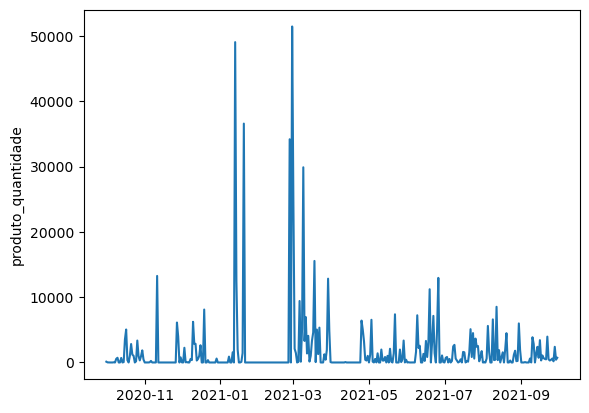

In [92]:
sns.lineplot(data=new_df,x=new_df.index,y='produto_quantidade')

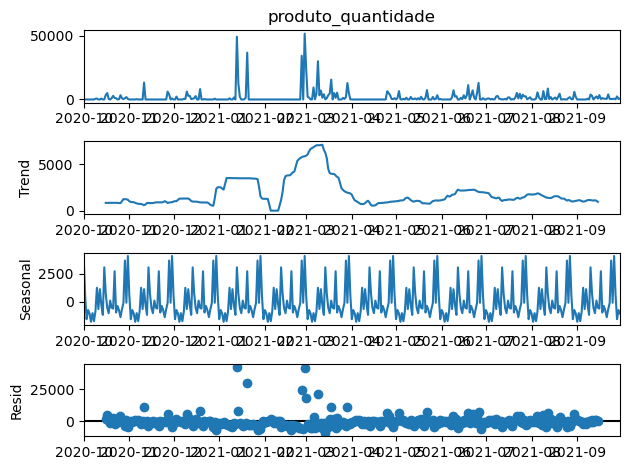

In [93]:
decomposed = seasonal_decompose(new_df['produto_quantidade'],period=30)
figure = decomposed.plot()

In [94]:
print('ADF Test Statistics:', adfuller(new_df['produto_quantidade'])[0])
print('ADF P-value:', adfuller(new_df['produto_quantidade'])[1])

ADF Test Statistics: -5.423710814997409
ADF P-value: 3.01968006991801e-06


Os dados se tratam de uma série temporal intermitente, isto é, uma série que contem intervalos entre os registros, onde observamos uma série de valores nulos (zeros). Esse tipo de série é comum quando lidamos com forecasting de demanda por produtos.

Após realizar a decomposição, é possível observar que a série não aparenta apresentar uma tendência. O teste Augmented Dickey-Fuller confirma que se trata de uma série estacionária.

Para lidar com esses dados, optei por seguir os seguintes passos:

1- Criar um modelo base

2- Realizar uma modelagem de Croston (método adequado para lidar com séries intermitentes)

3- Transformar em um problema de regressão, adicionando features que podem impactar na demanda pelo produto 

Tendo em vista que o objetivo do projeto é realizar uma projeção de até 4 janelas temporais à frente, os modelos serão defasados em 4 dias.

É importante ainda destacar que, na descrição do projeto foi solicitada a utilização das métricas RMSE e MAPE para a avaliação do modelo. Porém, por se tratar de uma série intermitente não é poissível utilizar o MAPE, pois o mesmo será indefinido nos pontos em que o valor seja 0

Por isso, para a avaliação da série será utilizado apenas o RMSE.

#### Modelagem

##### Baseline Model

Para o modelo base, optei por uma métrica simples: a média dos últimos 7 dias.

In [95]:
new_df['weekly_avg'] = new_df['produto_quantidade'].shift(4).rolling(7, min_periods=1).mean()

new_df.fillna(0,inplace=True)

RMSE: 5624.671022010067


<AxesSubplot:>

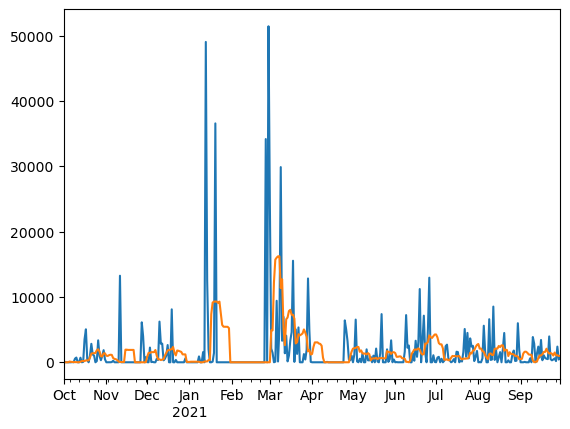

In [96]:
print('RMSE:',rmse(new_df['weekly_avg'], new_df['produto_quantidade'],))

new_df['produto_quantidade'].plot()
new_df['weekly_avg'].plot()

O modelo base apresentou um RMSE de 5655, que servirá como valor comparativo para as próximas implementações. 

Ao avaliar graficamente as projeções e os valores reais, fica claro que o modelo tem uma defasagem e não captura os movimentos abruptos com precisão.

##### Croston Model

O modelo de Croston é uma técnica de forecasting de séries temporais capaz de lidar com séries intermitentes. Esse modelo considera o nível médio de demanda, o tempo médio entre duas ocorrências (aqui denotadas como valores diferentes de zero) e realiza a projeção com base no nível de demanda e a probabilidade de ocorrer um evento.

RMSE: 6479.779359038174


<AxesSubplot:>

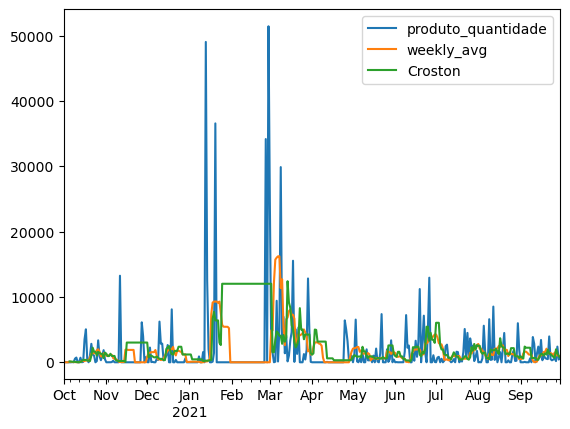

In [97]:
cros_df = Croston(new_df.produto_quantidade) # Gerando o modelo de Croston
cros_df = cros_df.dropna()

pred_croston = cros_df.Forecast.head(len(df)) # Realizando projeções
print('RMSE: ' + str(rmse(new_df.produto_quantidade,pred_croston))) # Calculando raiz do erro quadrado médio

new_df['Croston'] = pred_croston.values
new_df['Croston'] = new_df['Croston'].shift(4) # Realizando defazagem das previsões
new_df.drop(['valor_total_venda', 'valor_unitario'],axis=1).plot() 

O resultado do modelo de Croston foi pior do que o modelo de base. Isso acontece principalmente por que o modelo não realiza ajustes quando não há ocorrências e a previsão do modelo se mantém estável, quando os valores reais são nulos.

##### Croston TBS

O modelo de Croston TBS é uma evolução do modelo anterior, que considera um ajuste nas suas projeções a medida que o tempo sem ocorrências aumenta. 

Esse ajuste reduz as projeções do modelo a medida que o intervalor entre às ocorrências aumente.

RMSE: 5579.358542423926


<AxesSubplot:>

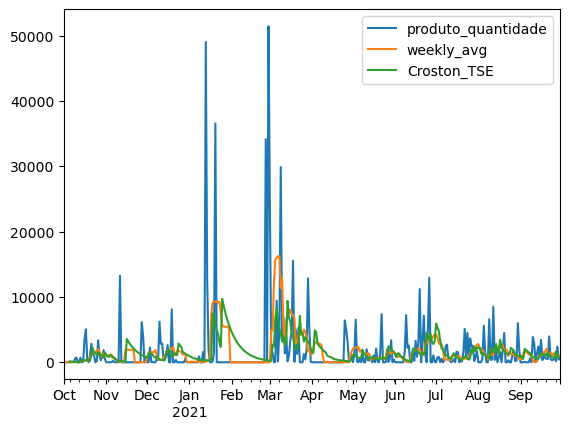

In [98]:
cros_df = Croston_TSB(new_df.produto_quantidade)
cros_df = cros_df.dropna()

pred_croston = cros_df.Forecast.head(len(df))
new_df['Croston_TSE'] = pred_croston.values
new_df['Croston_TSE'] = new_df['Croston_TSE'].shift(4)

pred_croston = cros_df.Forecast.head(len(df))
print('RMSE: ' + str(rmse(new_df.dropna().produto_quantidade,new_df['Croston_TSE'].dropna())))

new_df.drop(['valor_total_venda', 'valor_unitario','Croston'],axis=1).plot()

In [99]:
new_df

,produto_quantidade,valor_total_venda,valor_unitario,weekly_avg,Croston,Croston_TSE
2020-10-01,120,3540.00,29.500000,0.000000,NaN,NaN
2020-10-02,14,13.58,0.970000,0.000000,NaN,NaN
2020-10-03,0,0.00,0.000000,0.000000,NaN,NaN
2020-10-04,0,0.00,0.000000,0.000000,NaN,NaN
2020-10-05,1,0.97,0.970000,120.000000,120.000000,120.000000
...,...,...,...,...,...,...
2021-09-26,600,19482.00,32.470000,1493.571429,695.454282,567.656641
2021-09-27,180,5790.00,32.166667,1074.857143,1988.667549,1652.368384
2021-09-28,2400,67807.80,28.253250,1072.714286,1392.288294,1177.180323
2021-09-29,420,13637.40,32.470000,978.428571,956.900725,822.486341


O modelo de Crostom TBS apresenta um resultado levemente superior ao nosso modelo basal com um RMSE de 5579.

Analisando graficamente, é possível observar que o modelo responde mais rapidamente em picos de demanda do que o modelo basal, porém, é mais lento em prever uma redução da demanda nos períodos sem ocorrência.

##### Crostom + Média

Buscando otimizar o modelo, foi testado uma média entre as projeções do modelo basal e do modelo de Croston TBS

RMSE: 5544.414637688864


<AxesSubplot:>

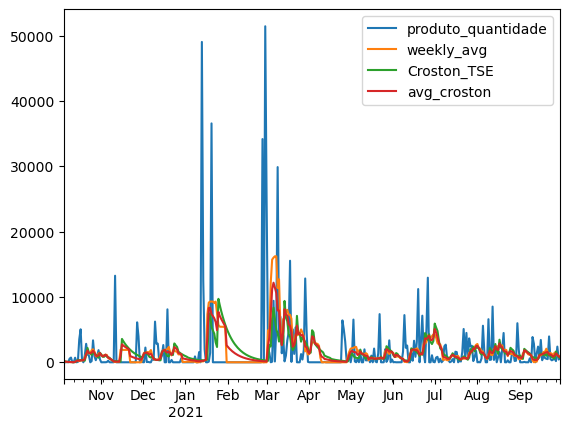

In [100]:
new_df.dropna(inplace=True)

new_df['avg_croston'] = (new_df['Croston_TSE']+new_df['weekly_avg'])/2

print('RMSE: ' + str(rmse(new_df.dropna().produto_quantidade,new_df.dropna().avg_croston)))

new_df.drop(['valor_total_venda', 'valor_unitario', 'Croston'],axis=1).plot()

A média entre os 2 modelos entregou um resultado melhor, com o RMSE de 5544, inferior aos anteriores.

#### Transformando em um problema de regressão

Em problemas de projeção de demanda com séries intermitentes, existem outros fatores que podem trazer uma explicação para a demanda futura. Nesta etapa, será feita uma análise em busca de features que possam ter poder explicativo.

<AxesSubplot:xlabel='sem_demanda', ylabel='produto_quantidade'>

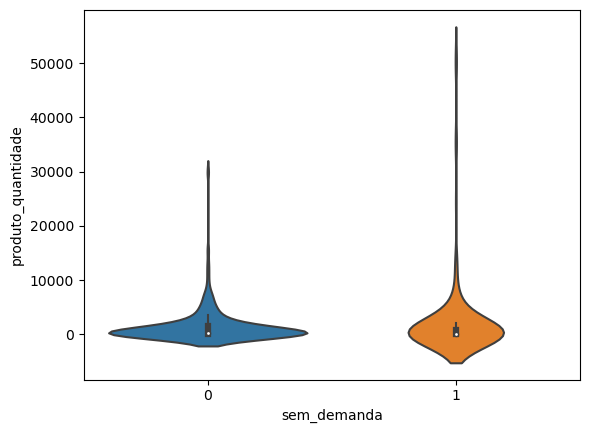

In [101]:
# Analisando features que podem influenciar demanda

new_df['dia_da_semana'] = new_df.index.day_of_week # Criando coluna com dia da semana
new_df['mes'] = new_df.index.month # Criando coluna com o mês
new_df['sem_demanda'] = [
                        1 if x == 0 else 0 for x in new_df['produto_quantidade'].shift(4)
                        ] # Coluna que indica se 4 dias antes houve demanda ou não
new_df['trimestre'] = new_df.index.quarter # Criando coluna com trimestre
new_df['valor_unit_shift'] = new_df['valor_unitario'].shift(4) # Defasando o valor unitário em 4 dias
new_df.fillna(0,inplace=True) # Preenchendo valores nulos com 0

# Plotando média de produtos em períodos sem demanda e com demanda
sns.violinplot( data = new_df, y = 'produto_quantidade', x= 'sem_demanda')
#new_df.groupby('sem_demanda').mean()['produto_quantidade'].plot(kind='bar') 

<AxesSubplot:xlabel='dia_da_semana'>

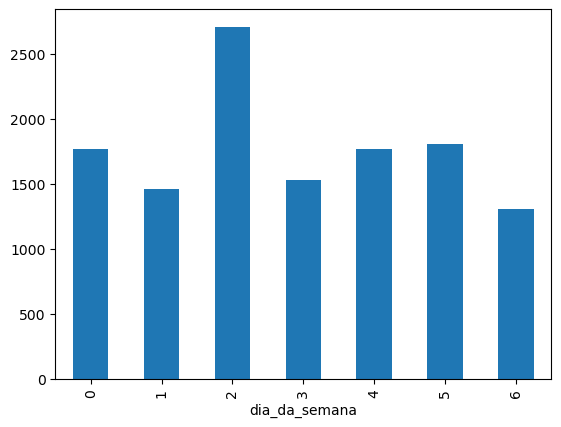

In [102]:
# Plotando média de produtos por mês
new_df.groupby('dia_da_semana').mean()['produto_quantidade'].plot(kind='bar')

<AxesSubplot:xlabel='trimestre'>

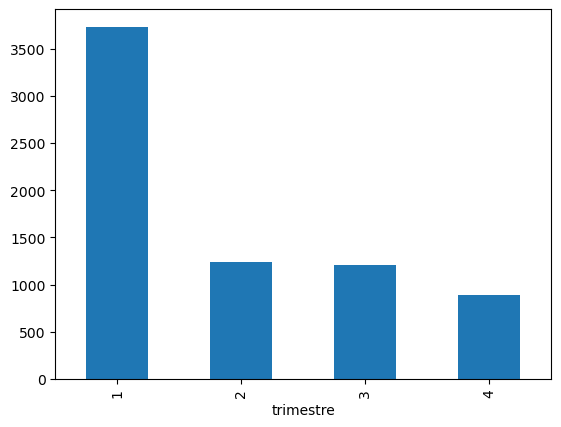

In [103]:
# Plotando média de produtos por trimestre
new_df.groupby('trimestre').mean()['produto_quantidade'].plot(kind='bar')

In [104]:
# Criando variável dummie indicando se a data é no primeiro trimestre
new_df['1_trimestre'] = [1 if x == 1 else 0 for x in new_df['trimestre']]

In [105]:
# Correlação entre o valor unitário defasado em 4 dias e a quantidade de produto
new_df['valor_unit_shift'].corr(new_df['produto_quantidade'])

-0.05425087203738421

Após a análise apresentada acima, temos que:
- Existe um diferença na distribuição dos resultados de quantidade de produto de acordo com a demanda anterior. No caso de períodos sem demanda, existe uma maior probabilidade de outliers.
- O produto e questão aparenta apresentar uma maior demanda no primeiro trimestre do ano. Por isso, foi criada uma variável dummie que identifica essa condição.
- O valor unitário defasado parece não ser correlacionado com a quantidade de produto vendido e também não existe uma relação clara entre dias da semana e a quantidade de produtos.

Para a modelagem, foi testado um RandomForest Regressor, utilizando as variáveis:
- sem_demanda: variável binária indicando de houve ou não demanda no período anterior (defasada em 4 períodos)
- 1_trimestre: variável binária indicando se a data em questão está ou não no primeiro trimestre do ano
- avg_croston: previsão obtida no modelo que considera a média entre o modelo de Croston TBS e a média móvel semanal (defasada em 4 períodos)

In [106]:
X = new_df[:-50][['sem_demanda','1_trimestre','avg_croston']]
y = new_df[:-50]['produto_quantidade']

X_test = new_df[-50:-4][['sem_demanda','1_trimestre','avg_croston']]
y_test = new_df[-50:-4]['produto_quantidade']

X_predict= new_df[-4:][['sem_demanda','1_trimestre','avg_croston']]
y_predict = new_df[-4:]['produto_quantidade']

rf_reg = RandomForestRegressor().fit(X, y)


RMSE: 2411.08449370544


<AxesSubplot:ylabel='produto_quantidade'>

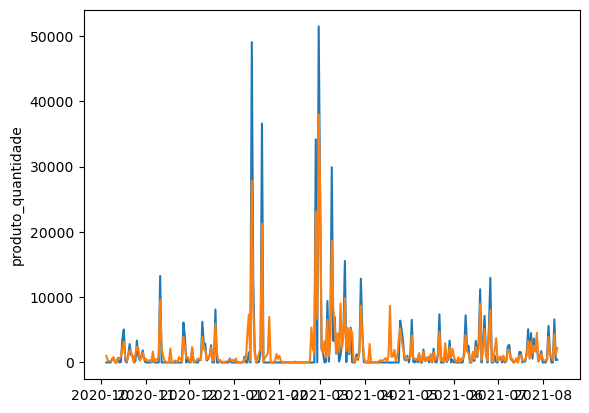

In [111]:
pred = rf_reg.predict(X)

print('RMSE: ' + str(rmse(y,pred)))

sns.lineplot(x=X.index,y=y)
sns.lineplot(x=X.index,y=pred)

A combinação com o Random Forest entregou a melhor previsão dentre os modelos testados, com uma significativa redução no RMSE, para 2197.

Graficamente, é possível notar uma melhor resposta aos picos de demanda, apesar da geração de alguns picos projetados que não aconteceram nos valores reais.

RMSE: 2168.30272737838


<AxesSubplot:ylabel='produto_quantidade'>

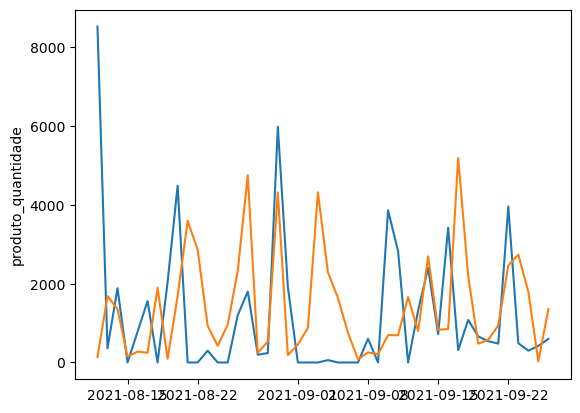

In [108]:
pred = rf_reg.predict(X_test)

print('RMSE: ' + str(rmse(y_test,pred)))

sns.lineplot(x=X_test.index,y=y_test)
sns.lineplot(x=X_test.index,y=pred)

O modelo apresentou um resultado consistente realizando previsões out-of-sample, alcançando um RMSE de 2160.

#### Previsão das 4 janelas seguintes

Por fim, a previsão das últimas 4 janelas da série, também out-of-sample, são exibidas abaixo. Por se tratar de um período onde os valores reais apresentaram uma menor volatilidade a métrica de erro foi até inferior ao observado no dataset de teste.

RMSE: 1042.3065471467594


<AxesSubplot:ylabel='produto_quantidade'>

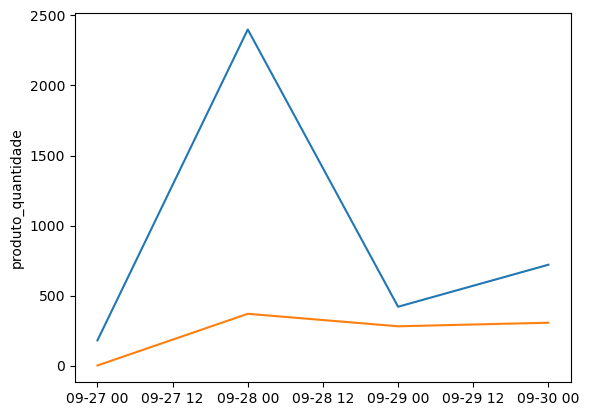

In [488]:
pred = rf_reg.predict(X_predict)

print('RMSE: ' + str(rmse(y_predict,pred)))

sns.lineplot(x=X_predict.index,y=y_predict)
sns.lineplot(x=X_predict.index,y=pred)